# Loading model

In [1]:
import tensorflow as tf

In [2]:
import os

In [3]:
model_filename = "keypoint_classifier.hdf5"
model_save_path = os.path.join('model', model_filename)

In [4]:
DIRECTION = {
    'up': 0,
    'down': 1,
    'back': 2,
    'forward': 3,
    'left': 4,
    'right': 5
}
INVERSE_DIRECTION = {val: key for key, val in DIRECTION.items()}

In [5]:
model = tf.keras.models.load_model(model_save_path)

2021-12-08 12:07:18.240995: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [10]:
model.weights

[<tf.Variable 'dense/kernel:0' shape=(42, 32) dtype=float32, numpy=
 array([[ 0.28536266, -0.17170145,  0.01691386, ...,  0.10488549,
          0.08943686, -0.16523671],
        [ 0.58007896,  0.18528442, -0.20502406, ..., -0.4396787 ,
         -0.14293262, -0.28677806],
        [-0.00782894,  0.0783958 , -0.12761739, ...,  0.05299959,
         -0.277816  ,  0.3873113 ],
        ...,
        [-0.05804154, -0.06494728,  0.0198838 , ...,  0.20319828,
          0.22082582,  0.00704322],
        [ 0.1441247 , -0.20837139,  0.1039812 , ..., -0.3770678 ,
         -0.02897057, -0.00083756],
        [ 0.4402409 , -0.12186212, -0.0781737 , ...,  0.17160358,
         -0.0155257 ,  0.03420025]], dtype=float32)>,
 <tf.Variable 'dense/bias:0' shape=(32,) dtype=float32, numpy=
 array([ 0.21120265,  0.11878837,  0.04358736,  0.02852655,  0.        ,
         0.0698735 , -0.02003215, -0.01524948,  0.        ,  0.07415266,
         0.0214069 ,  0.        , -0.01923835, -0.01519306,  0.05001137,
       

# Using Alternative dataset to show model works for demo purposes

In [11]:
import numpy as np
import cv2
%matplotlib inline

In [12]:
OUTPUT_DATA_DIR = 'data'
dataset_path = os.path.join(OUTPUT_DATA_DIR, 
                            "keypoints_96e338c5c42b4a1ebf2c7726d4f37756.csv")
KEYPOINTS_FNAME = 'keypoints'

In [13]:
data = np.loadtxt(
    dataset_path,
    delimiter=',',
    dtype='float32',
#     usecols=list(range(1, (21 * 2) +1))
)

In [14]:
len(data)

120

In [15]:
np.random.shuffle(data)

In [16]:
X_data = data[:, 1:]

In [17]:
len(X_data)

120

In [18]:
Y_data = data[:, 0]

In [19]:
Y_data.astype('int32')

array([5, 0, 1, 1, 2, 1, 0, 0, 5, 3, 4, 3, 1, 3, 3, 3, 1, 4, 0, 3, 1, 1,
       1, 1, 4, 5, 2, 4, 2, 3, 5, 2, 3, 0, 0, 0, 5, 3, 2, 1, 0, 5, 2, 4,
       0, 4, 4, 1, 1, 4, 2, 4, 2, 5, 4, 2, 2, 2, 5, 1, 4, 0, 0, 4, 2, 0,
       3, 4, 5, 0, 4, 1, 4, 5, 5, 3, 4, 1, 2, 2, 2, 0, 3, 3, 0, 0, 0, 3,
       5, 3, 3, 0, 5, 0, 5, 4, 2, 4, 1, 5, 5, 0, 2, 2, 4, 1, 5, 5, 5, 4,
       3, 3, 5, 1, 2, 3, 3, 2, 1, 1], dtype=int32)

In [20]:
labels = [INVERSE_DIRECTION[y] for y in Y_data]

In [ ]:
Y_data

In [ ]:
print("Y_pred\tY\t")
for i in range(120):
    predict = model.predict(np.array([X_data[i]]))
    y_cap = np.argmax(np.squeeze(predict))
    print(f"{INVERSE_DIRECTION[y_cap]}\t{labels[i]}\n")
    

## Confusion martrix

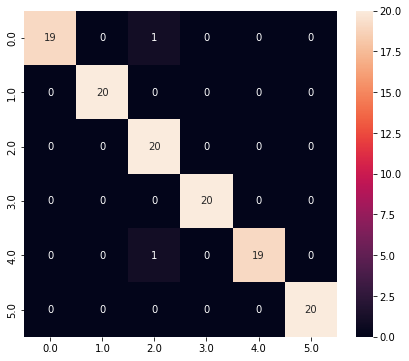

Classification Report
              precision    recall  f1-score   support

         0.0       1.00      0.95      0.97        20
         1.0       1.00      1.00      1.00        20
         2.0       0.91      1.00      0.95        20
         3.0       1.00      1.00      1.00        20
         4.0       1.00      0.95      0.97        20
         5.0       1.00      1.00      1.00        20

    accuracy                           0.98       120
   macro avg       0.98      0.98      0.98       120
weighted avg       0.98      0.98      0.98       120



In [21]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report


def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(Y_data, y_pred))

Y_pred = model.predict(X_data)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(Y_data, y_pred)

# Showing live demo using cv2

In [1]:
import mediapipe as mp
import cv2
import numpy as np

In [2]:
def write_text_on_video(frame, direction, color=(255,255,255)):
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(frame,
               f"{direction}",
               (50, 50),
                font, 1, 
                color,
                2,
                cv2.LINE_4)

In [3]:
def extract_keypoints(landmark):
    if not landmark: return
    keypoints = []
    for data_point in enumerate(landmark[0].landmark):
        keypoints.extend(
            [data_point[1].x, data_point[1].y]
        )
    return keypoints
    

In [4]:
def add_hands_connection(frame, hands):
    image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    image.flags.writeable = False
    results = hands.process(image)
    image.flags.writeable = True
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    if results.multi_hand_landmarks:
        for num, hand in enumerate(results.multi_hand_landmarks):
            mp_drawing.draw_landmarks(
                image, hand, 
                mp_hands.HAND_CONNECTIONS,
                mp_drawing.DrawingSpec(color=(121,22,78), thickness=2, circle_radius=4),
                mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2),
            )
    return image, results

In [5]:
def predict_label(keypoints):
    return INVERSE_DIRECTION[
        np.argmax(np.squeeze(
            model.predict([keypoints])
                  ))]

In [6]:
mp_drawing = mp.solutions.drawing_utils
mp_hands = mp.solutions.hands

In [ ]:
cap = cv2.VideoCapture(0)
with mp_hands.Hands(min_detection_confidence=0.8, min_tracking_confidence=0.7) as hands:
    while cap.isOpened():
        ret, frame = cap.read()
        image, results = add_hands_connection(frame, hands)
        image = cv2.flip(image, 1)
        landmark_result = results.multi_hand_landmarks
        if landmark_result:
            keypoints = extract_keypoints(landmark_result)
            y_cap = predict_label(keypoints)
            write_text_on_video(image, y_cap)
        cv2.imshow("hand tracking", image)
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()
    cv2.waitKey(1)

In [21]:
cap = cv2.VideoCapture(0)
with mp_hands.Hands(min_detection_confidence=0.8, min_tracking_confidence=0.7) as hands:
    while cap.isOpened():
        ret, frame = cap.read()
        image, results = add_hands_connection(frame, hands)
        image = cv2.flip(image, 1)
        landmark_result = results.multi_hand_landmarks
        if landmark_result:
            keypoints = extract_keypoints(landmark_result)
            y_cap = predict_label(keypoints)
            write_text_on_video(image, y_cap)
        cv2.imshow("hand", image)
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()
    cv2.waitKey(1)